In [ ]:
import sys
sys.path.append("../")

import math
import pickle
import torch
import numpy as np
from models.LASE_unshared_normalized import LASE
from models.RDPG_GD import RDPG_GD_Armijo, coordinate_descent
from models.SVD_truncate import embed_scipy
from graspologic.embed import AdjacencySpectralEmbed 
from torch_geometric.utils import to_dense_adj, stochastic_blockmodel_graph, erdos_renyi_graph
import matplotlib.pyplot as plt 
from training.get_init import get_x_init
from models.SVD_truncate import align_Xs

# SBM-2

In [20]:
torch.manual_seed(42)

d = 2
gd_steps = 10
device = 'cuda'

lase_M07 = LASE(d, d, gd_steps)
lase_M07.load_state_dict(torch.load('../saved_models/lase_unshared_d2_normalized_unbalanced_rand_10steps_M07.pt'))
lase_M07.to(device)
lase_M07.eval()

num_nodes = 1000
n = [700, 300]
p = [
     [0.9, 0.1],
     [0.1, 0.5]
]


edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)


n_1 = 10
n_2 = 5
selected_nodes = list(range(n_1)) + list(range(n[0],n[0]+n_2))
print(selected_nodes)

M07 = torch.ones([num_nodes,num_nodes]).squeeze(0)
for i in selected_nodes:
    votos = (torch.rand(1, num_nodes) < 0.7).int()
    M07[i,:] = votos
    M07[:,i] = votos


x = torch.rand((num_nodes, d)).to(device)


x_lase_M07 = lase_M07(x, edge_index, edge_index_2, M07.nonzero().t().contiguous().to(device))
x_lase_M07 = x_lase_M07.detach()
x_lase_M07 = x_lase_M07.to('cpu')


x_gd_M07, cost, k = RDPG_GD_Armijo(x, edge_index, M07.nonzero().t().contiguous().to(device))
x_gd_M07 = x_gd_M07.detach()
x_gd_M07 = x_gd_M07.to('cpu')
print(k)

x_gd_M07_10, cost, k = RDPG_GD_Armijo(x, edge_index, M07.nonzero().t().contiguous().to(device), max_iter=10)
x_gd_M07_10 = x_gd_M07_10.detach()
x_gd_M07_10 = x_gd_M07_10.to('cpu')


adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
masked_adj = adj_matrix*M07
x_svd_M07 = embed_scipy(masked_adj.nonzero().t().contiguous(), d)

x_gd_M07  = align_Xs(x_gd_M07, x_svd_M07)
x_lase_M07 = align_Xs(x_lase_M07, x_svd_M07)
x_gd_M07_10 = align_Xs(x_gd_M07_10, x_svd_M07)



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 700, 701, 702, 703, 704]
37


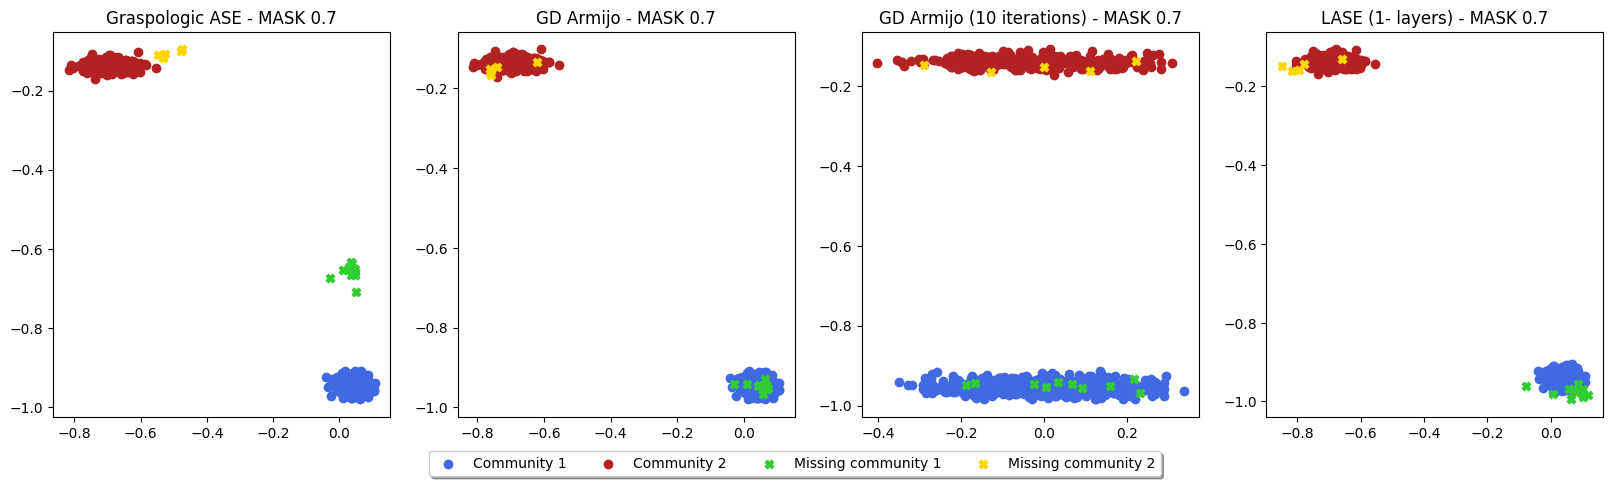

In [21]:
fig, axes = plt.subplots(1, 4, figsize =(20,5))
axes[0].set_title('Graspologic ASE - MASK 0.7')
axes[0].scatter(x_svd_M07[n_1:n[0],0],x_svd_M07[n_1:n[0]:,1], c='royalblue',marker='o',label='Community 1')
axes[0].scatter(x_svd_M07[n[0]+n_2:,0],x_svd_M07[n[0]+n_2:,1], c='firebrick',marker='o',label='Community 2')
axes[0].scatter(x_svd_M07[:n_1,0],x_svd_M07[:n_1,1], c='limegreen',marker='X',label='Missing community 1')
axes[0].scatter(x_svd_M07[n[0]:n[0]+n_2,0],x_svd_M07[n[0]:n[0]+n_2,1], c='gold',marker='X',label='Missing community 2')
axes[1].set_title('GD Armijo - MASK 0.7')
axes[1].scatter(x_gd_M07[n_1:n[0],0],x_gd_M07[n_1:n[0]:,1], c='royalblue',marker='o',label='Community 1')
axes[1].scatter(x_gd_M07[n[0]+n_2:,0],x_gd_M07[n[0]+n_2:,1], c='firebrick',marker='o',label='Community 2')
axes[1].scatter(x_gd_M07[:n_1,0],x_gd_M07[:n_1,1], c='limegreen',marker='X',label='Missing community 1')
axes[1].scatter(x_gd_M07[n[0]:n[0]+n_2,0],x_gd_M07[n[0]:n[0]+n_2,1], c='gold',marker='X',label='Missing community 2')
axes[2].set_title('GD Armijo (10 iterations) - MASK 0.7')
axes[2].scatter(x_gd_M07_10[n_1:n[0],0],x_gd_M07_10[n_1:n[0]:,1], c='royalblue',marker='o',label='Community 1')
axes[2].scatter(x_gd_M07_10[n[0]+n_2:,0],x_gd_M07_10[n[0]+n_2:,1], c='firebrick',marker='o',label='Community 2')
axes[2].scatter(x_gd_M07_10[:n_1,0],x_gd_M07_10[:n_1,1], c='limegreen',marker='X',label='Missing community 1')
axes[2].scatter(x_gd_M07_10[n[0]:n[0]+n_2,0],x_gd_M07_10[n[0]:n[0]+n_2,1], c='gold',marker='X',label='Missing community 2')
axes[3].set_title('LASE (1- layers) - MASK 0.7')
axes[3].scatter(x_lase_M07[n_1:n[0],0],x_lase_M07[n_1:n[0]:,1], c='royalblue',marker='o',label='Community 1')
axes[3].scatter(x_lase_M07[n[0]+n_2:,0],x_lase_M07[n[0]+n_2:,1], c='firebrick',marker='o',label='Community 2')
axes[3].scatter(x_lase_M07[:n_1,0],x_lase_M07[:n_1,1], c='limegreen',marker='X',label='Missing community 1')
axes[3].scatter(x_lase_M07[n[0]:n[0]+n_2,0],x_lase_M07[n[0]:n[0]+n_2,1], c='gold',marker='X',label='Missing community 2')
plt.legend(loc='upper center', bbox_to_anchor=(-1.4, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()

In [22]:
torch.manual_seed(42)

d = 2
gd_steps = 10
device = 'cuda'


lase_M05 = LASE(d, d, gd_steps)
lase_M05.load_state_dict(torch.load('../saved_models/lase_unshared_d2_normalized_unbalanced_rand_10steps_M05.pt'))
lase_M05.to(device)
lase_M05.eval()


num_nodes = 2000
n = [1400, 600]
p = [
     [0.9, 0.1],
     [0.1, 0.5]
]


edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)


n_1 = 10
n_2 = 5
selected_nodes = list(range(n_1)) + list(range(n[0],n[0]+n_2))
print(selected_nodes)


M05 = torch.ones([num_nodes,num_nodes]).squeeze(0)
for i in selected_nodes:
    votos = (torch.rand(1, num_nodes) < 0.5).int()
    M05[i,:] = votos
    M05[:,i] = votos
    

x = torch.rand((num_nodes, d)).to(device)


x_lase_M05 = lase_M05(x, edge_index, edge_index_2, M05.nonzero().t().contiguous().to(device))
x_lase_M05 = x_lase_M05.detach()
x_lase_M05 = x_lase_M05.to('cpu')

x_gd_M05, cost, k = RDPG_GD_Armijo(x, edge_index, M05.nonzero().t().contiguous().to(device))
x_gd_M05 = x_gd_M05.detach()
x_gd_M05 = x_gd_M05.to('cpu')

x_gd_M05_10, cost, k = RDPG_GD_Armijo(x, edge_index, M05.nonzero().t().contiguous().to(device), max_iter=10)
x_gd_M05_10 = x_gd_M05_10.detach()
x_gd_M05_10 = x_gd_M05_10.to('cpu')


adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
masked_adj = adj_matrix*M05
x_svd_M05 = embed_scipy(masked_adj.nonzero().t().contiguous(), d)

x_gd_M05  = align_Xs(x_gd_M05, x_svd_M05)
x_lase_M05 = align_Xs(x_lase_M05, x_svd_M05)
x_gd_M05_10 = align_Xs(x_gd_M05_10, x_svd_M05)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1400, 1401, 1402, 1403, 1404]


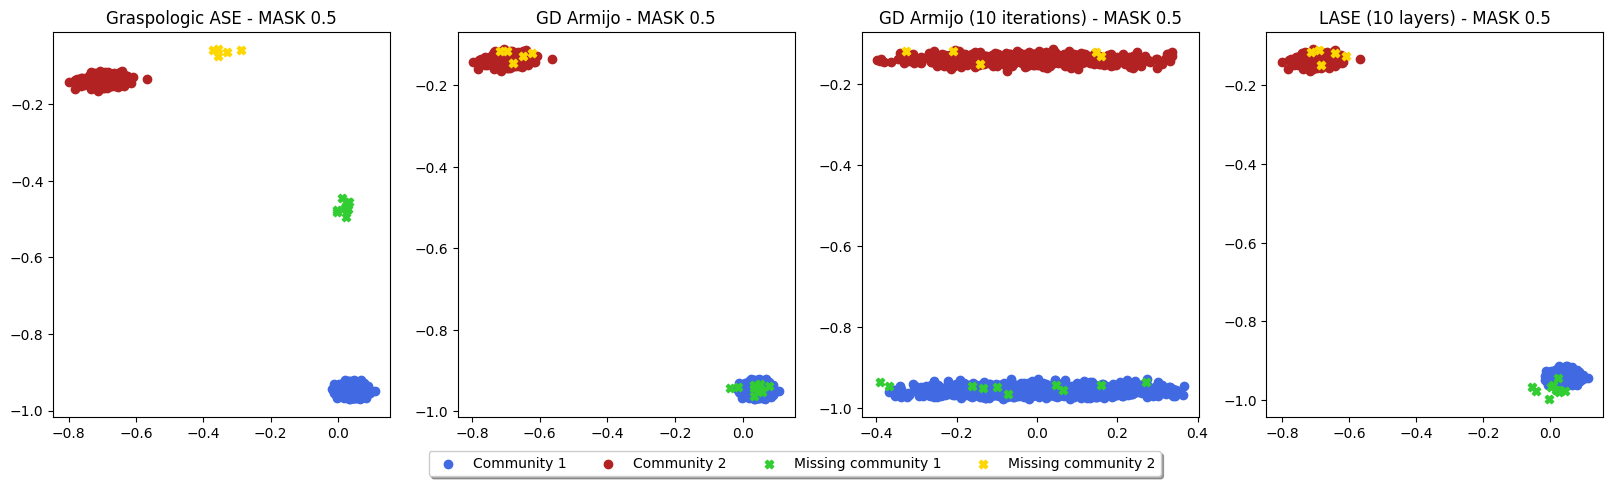

In [23]:
fig, axes = plt.subplots(1, 4, figsize =(20,5))
axes[0].set_title('Graspologic ASE - MASK 0.5')
axes[0].scatter(x_svd_M05[n_1:n[0],0],x_svd_M05[n_1:n[0]:,1], c='royalblue',marker='o',label='Community 1')
axes[0].scatter(x_svd_M05[n[0]+n_2:,0],x_svd_M05[n[0]+n_2:,1], c='firebrick',marker='o',label='Community 2')
axes[0].scatter(x_svd_M05[:n_1,0],x_svd_M05[:n_1,1], c='limegreen',marker='X',label='Missing community 1')
axes[0].scatter(x_svd_M05[n[0]:n[0]+n_2,0],x_svd_M05[n[0]:n[0]+n_2,1], c='gold',marker='X',label='Missing community 2')
axes[1].set_title('GD Armijo - MASK 0.5')
axes[1].scatter(x_gd_M05[n_1:n[0],0],x_gd_M05[n_1:n[0]:,1], c='royalblue',marker='o',label='Community 1')
axes[1].scatter(x_gd_M05[n[0]+n_2:,0],x_gd_M05[n[0]+n_2:,1], c='firebrick',marker='o',label='Community 2')
axes[1].scatter(x_gd_M05[:n_1,0],x_gd_M05[:n_1,1], c='limegreen',marker='X',label='Missing community 1')
axes[1].scatter(x_gd_M05[n[0]:n[0]+n_2,0],x_gd_M05[n[0]:n[0]+n_2,1], c='gold',marker='X',label='Missing community 2')
axes[2].set_title('GD Armijo (10 iterations) - MASK 0.5')
axes[2].scatter(x_gd_M05_10[n_1:n[0],0],x_gd_M05_10[n_1:n[0]:,1], c='royalblue',marker='o',label='Community 1')
axes[2].scatter(x_gd_M05_10[n[0]+n_2:,0],x_gd_M05_10[n[0]+n_2:,1], c='firebrick',marker='o',label='Community 2')
axes[2].scatter(x_gd_M05_10[:n_1,0],x_gd_M05_10[:n_1,1], c='limegreen',marker='X',label='Missing community 1')
axes[2].scatter(x_gd_M05_10[n[0]:n[0]+n_2,0],x_gd_M05_10[n[0]:n[0]+n_2,1], c='gold',marker='X',label='Missing community 2')
axes[3].set_title('LASE (10 layers) - MASK 0.5')
axes[3].scatter(x_lase_M05[n_1:n[0],0],x_lase_M05[n_1:n[0]:,1], c='royalblue',marker='o',label='Community 1')
axes[3].scatter(x_lase_M05[n[0]+n_2:,0],x_lase_M05[n[0]+n_2:,1], c='firebrick',marker='o',label='Community 2')
axes[3].scatter(x_lase_M05[:n_1,0],x_lase_M05[:n_1,1], c='limegreen',marker='X',label='Missing community 1')
axes[3].scatter(x_lase_M05[n[0]:n[0]+n_2,0],x_lase_M05[n[0]:n[0]+n_2,1], c='gold',marker='X',label='Missing community 2')
plt.legend(loc='upper center', bbox_to_anchor=(-1.4, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()

In [24]:
torch.manual_seed(42)

d = 2
gd_steps = 10
device = 'cuda'


lase_M03 = LASE(d, d, gd_steps)
lase_M03.load_state_dict(torch.load('../saved_models/lase_unshared_d2_normalized_unbalanced_rand_10steps_M03.pt'))
lase_M03.to(device)
lase_M03.eval()


num_nodes = 2000
n = [1400, 600]
p = [
     [0.9, 0.1],
     [0.1, 0.5]
]


edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)


n_1 = 10
n_2 = 5
selected_nodes = list(range(n_1)) + list(range(n[0],n[0]+n_2))
print(selected_nodes)


M03 = torch.ones([num_nodes,num_nodes]).squeeze(0)
for i in selected_nodes:
    votos = (torch.rand(1, num_nodes) < 0.3).int()
    M03[i,:] = votos
    M03[:,i] = votos
    

x = torch.rand((num_nodes, d)).to(device)


x_lase_M03 = lase_M03(x, edge_index, edge_index_2, M03.nonzero().t().contiguous().to(device))
x_lase_M03 = x_lase_M03.detach()
x_lase_M03 = x_lase_M03.to('cpu')

x_gd_M03, cost, k = RDPG_GD_Armijo(x, edge_index, M03.nonzero().t().contiguous().to(device))
x_gd_M03 = x_gd_M03.detach()
x_gd_M03 = x_gd_M03.to('cpu')

x_gd_M03_10, cost, k = RDPG_GD_Armijo(x, edge_index, M03.nonzero().t().contiguous().to(device), max_iter=10)
x_gd_M03_10 = x_gd_M03_10.detach()
x_gd_M03_10 = x_gd_M03_10.to('cpu')


adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
masked_adj = adj_matrix*M03
x_svd_M03 = embed_scipy(masked_adj.nonzero().t().contiguous(), d)

x_gd_M03  = align_Xs(x_gd_M03, x_svd_M03)
x_lase_M03 = align_Xs(x_lase_M03, x_svd_M03)
x_gd_M03_10 = align_Xs(x_gd_M03_10, x_svd_M03)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1400, 1401, 1402, 1403, 1404]


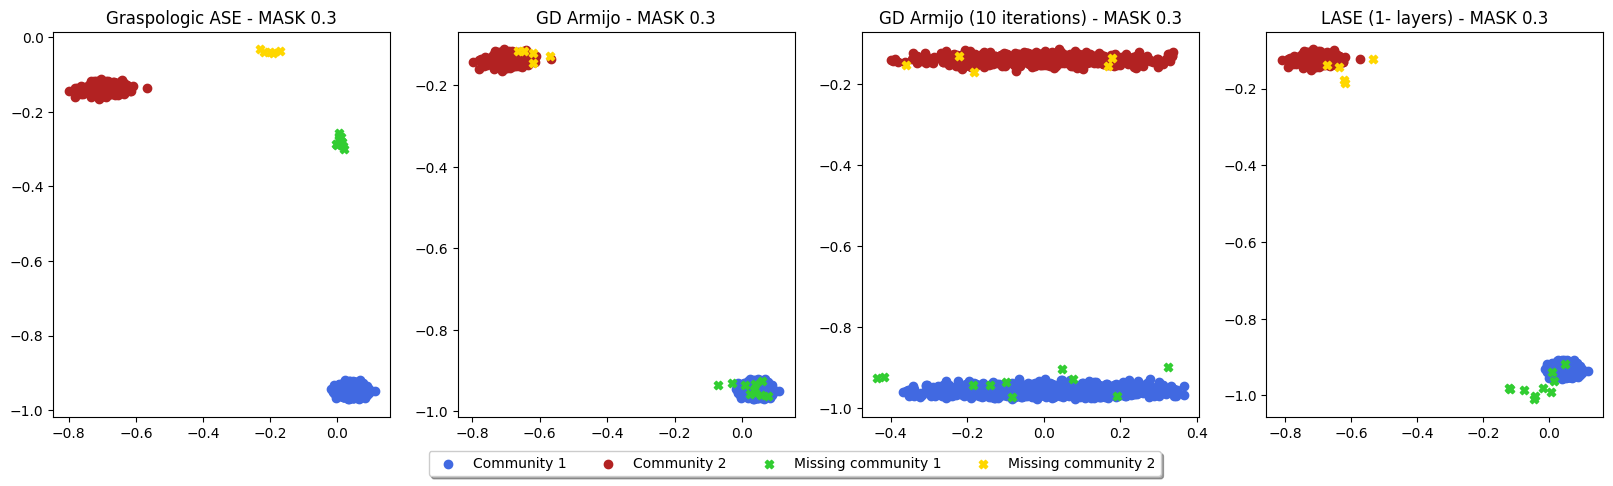

In [26]:
fig, axes = plt.subplots(1, 4, figsize =(20,5))
axes[0].set_title('Graspologic ASE - MASK 0.3')
axes[0].scatter(x_svd_M03[n_1:n[0],0],x_svd_M03[n_1:n[0]:,1], c='royalblue',marker='o',label='Community 1')
axes[0].scatter(x_svd_M03[n[0]+n_2:,0],x_svd_M03[n[0]+n_2:,1], c='firebrick',marker='o',label='Community 2')
axes[0].scatter(x_svd_M03[:n_1,0],x_svd_M03[:n_1,1], c='limegreen',marker='X',label='Missing community 1')
axes[0].scatter(x_svd_M03[n[0]:n[0]+n_2,0],x_svd_M03[n[0]:n[0]+n_2,1], c='gold',marker='X',label='Missing community 2')
axes[1].set_title('GD Armijo - MASK 0.3')
axes[1].scatter(x_gd_M03[n_1:n[0],0],x_gd_M03[n_1:n[0]:,1], c='royalblue',marker='o',label='Community 1')
axes[1].scatter(x_gd_M03[n[0]+n_2:,0],x_gd_M03[n[0]+n_2:,1], c='firebrick',marker='o',label='Community 2')
axes[1].scatter(x_gd_M03[:n_1,0],x_gd_M03[:n_1,1], c='limegreen',marker='X',label='Missing community 1')
axes[1].scatter(x_gd_M03[n[0]:n[0]+n_2,0],x_gd_M05[n[0]:n[0]+n_2,1], c='gold',marker='X',label='Missing community 2')
axes[2].set_title('GD Armijo (10 iterations) - MASK 0.3')
axes[2].scatter(x_gd_M03_10[n_1:n[0],0],x_gd_M03_10[n_1:n[0]:,1], c='royalblue',marker='o',label='Community 1')
axes[2].scatter(x_gd_M03_10[n[0]+n_2:,0],x_gd_M03_10[n[0]+n_2:,1], c='firebrick',marker='o',label='Community 2')
axes[2].scatter(x_gd_M03_10[:n_1,0],x_gd_M03_10[:n_1,1], c='limegreen',marker='X',label='Missing community 1')
axes[2].scatter(x_gd_M03_10[n[0]:n[0]+n_2,0],x_gd_M03_10[n[0]:n[0]+n_2,1], c='gold',marker='X',label='Missing community 2')
axes[3].set_title('LASE (1- layers) - MASK 0.3')
axes[3].scatter(x_lase_M03[n_1:n[0],0],x_lase_M03[n_1:n[0]:,1], c='royalblue',marker='o',label='Community 1')
axes[3].scatter(x_lase_M03[n[0]+n_2:,0],x_lase_M03[n[0]+n_2:,1], c='firebrick',marker='o',label='Community 2')
axes[3].scatter(x_lase_M03[:n_1,0],x_lase_M03[:n_1,1], c='limegreen',marker='X',label='Missing community 1')
axes[3].scatter(x_lase_M03[n[0]:n[0]+n_2,0],x_lase_M03[n[0]:n[0]+n_2,1], c='gold',marker='X',label='Missing community 2')
plt.legend(loc='upper center', bbox_to_anchor=(-1.4, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()

In [27]:
torch.manual_seed(42)

d = 2
gd_steps = 10
device = 'cuda'


lase_M01 = LASE(d, d, gd_steps)
lase_M01.load_state_dict(torch.load('../saved_models/lase_unshared_d2_normalized_unbalanced_rand_10steps_M01.pt'))
lase_M01.to(device)
lase_M01.eval()


num_nodes = 2000
n = [1400, 600]
p = [
     [0.9, 0.1],
     [0.1, 0.5]
]


edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)


n_1 = 10
n_2 = 5
selected_nodes = list(range(n_1)) + list(range(n[0],n[0]+n_2))
print(selected_nodes)


M01 = torch.ones([num_nodes,num_nodes]).squeeze(0)
for i in selected_nodes:
    votos = (torch.rand(1, num_nodes) < 0.1).int()
    M01[i,:] = votos
    M01[:,i] = votos
    

x = torch.rand((num_nodes, d)).to(device)


x_lase_M01 = lase_M01(x, edge_index, edge_index_2, M01.nonzero().t().contiguous().to(device))
x_lase_M01 = x_lase_M01.detach()
x_lase_M01 = x_lase_M01.to('cpu')

x_gd_M01, cost, k = RDPG_GD_Armijo(x, edge_index, M01.nonzero().t().contiguous().to(device))
x_gd_M01 = x_gd_M01.detach()
x_gd_M01 = x_gd_M01.to('cpu')

x_gd_M01_10, cost, k = RDPG_GD_Armijo(x, edge_index, M01.nonzero().t().contiguous().to(device), max_iter=10)
x_gd_M01_10 = x_gd_M01_10.detach()
x_gd_M01_10 = x_gd_M01_10.to('cpu')


adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
masked_adj = adj_matrix*M01
x_svd_M01 = embed_scipy(masked_adj.nonzero().t().contiguous(), d)

x_gd_M01  = align_Xs(x_gd_M01, x_svd_M01)
x_lase_M01 = align_Xs(x_lase_M01, x_svd_M01)
x_gd_M01_10 = align_Xs(x_gd_M01_10, x_svd_M01)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1400, 1401, 1402, 1403, 1404]


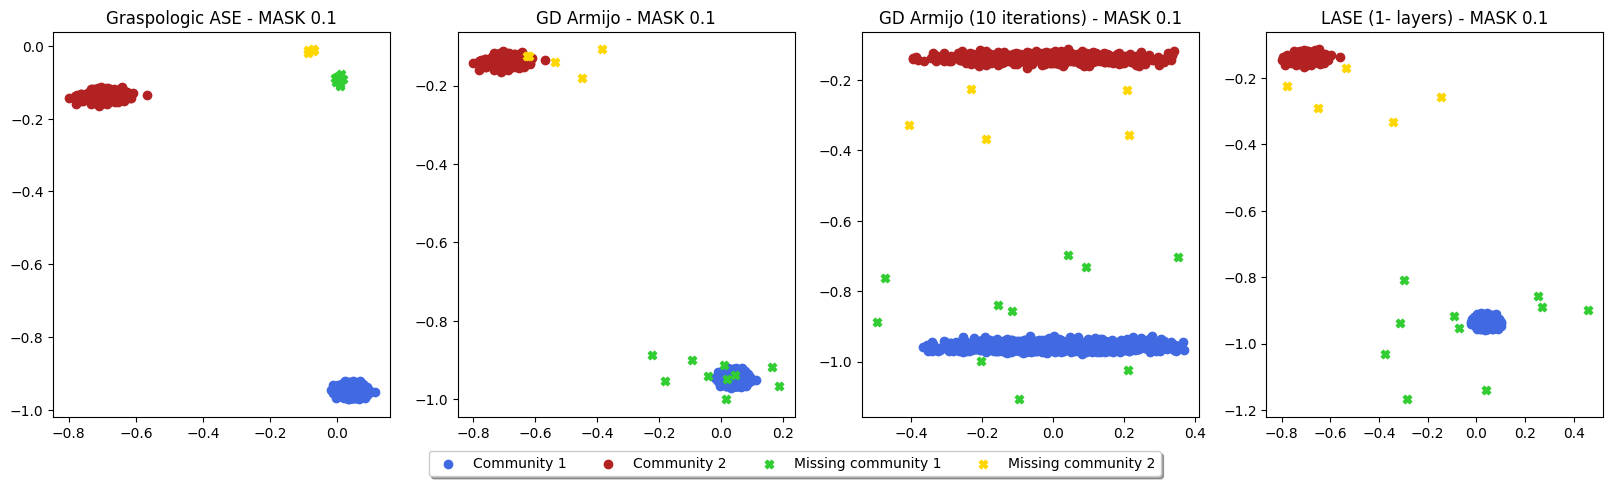

In [28]:
fig, axes = plt.subplots(1, 4, figsize =(20,5))
axes[0].set_title('Graspologic ASE - MASK 0.1')
axes[0].scatter(x_svd_M01[n_1:n[0],0],x_svd_M01[n_1:n[0]:,1], c='royalblue',marker='o',label='Community 1')
axes[0].scatter(x_svd_M01[n[0]+n_2:,0],x_svd_M01[n[0]+n_2:,1], c='firebrick',marker='o',label='Community 2')
axes[0].scatter(x_svd_M01[:n_1,0],x_svd_M01[:n_1,1], c='limegreen',marker='X',label='Missing community 1')
axes[0].scatter(x_svd_M01[n[0]:n[0]+n_2,0],x_svd_M01[n[0]:n[0]+n_2,1], c='gold',marker='X',label='Missing community 2')
axes[1].set_title('GD Armijo - MASK 0.1')
axes[1].scatter(x_gd_M01[n_1:n[0],0],x_gd_M01[n_1:n[0]:,1], c='royalblue',marker='o',label='Community 1')
axes[1].scatter(x_gd_M01[n[0]+n_2:,0],x_gd_M01[n[0]+n_2:,1], c='firebrick',marker='o',label='Community 2')
axes[1].scatter(x_gd_M01[:n_1,0],x_gd_M01[:n_1,1], c='limegreen',marker='X',label='Missing community 1')
axes[1].scatter(x_gd_M01[n[0]:n[0]+n_2,0],x_gd_M01[n[0]:n[0]+n_2,1], c='gold',marker='X',label='Missing community 2')
axes[2].set_title('GD Armijo (10 iterations) - MASK 0.1')
axes[2].scatter(x_gd_M01_10[n_1:n[0],0],x_gd_M01_10[n_1:n[0]:,1], c='royalblue',marker='o',label='Community 1')
axes[2].scatter(x_gd_M01_10[n[0]+n_2:,0],x_gd_M01_10[n[0]+n_2:,1], c='firebrick',marker='o',label='Community 2')
axes[2].scatter(x_gd_M01_10[:n_1,0],x_gd_M01_10[:n_1,1], c='limegreen',marker='X',label='Missing community 1')
axes[2].scatter(x_gd_M01_10[n[0]:n[0]+n_2,0],x_gd_M01_10[n[0]:n[0]+n_2,1], c='gold',marker='X',label='Missing community 2')
axes[3].set_title('LASE (1- layers) - MASK 0.1')
axes[3].scatter(x_lase_M01[n_1:n[0],0],x_lase_M01[n_1:n[0]:,1], c='royalblue',marker='o',label='Community 1')
axes[3].scatter(x_lase_M01[n[0]+n_2:,0],x_lase_M01[n[0]+n_2:,1], c='firebrick',marker='o',label='Community 2')
axes[3].scatter(x_lase_M01[:n_1,0],x_lase_M01[:n_1,1], c='limegreen',marker='X',label='Missing community 1')
axes[3].scatter(x_lase_M01[n[0]:n[0]+n_2,0],x_lase_M01[n[0]:n[0]+n_2,1], c='gold',marker='X',label='Missing community 2')
plt.legend(loc='upper center', bbox_to_anchor=(-1.4, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()


# SBM-3

In [92]:
d = 3
gd_steps = 5
device = 'cpu'

lase = LASE(d, d, gd_steps)
lase.load_state_dict(torch.load('../saved_models/lase_unshared_d3_normalized_unbalanced_rand.pt'))
lase.to(device)
lase.eval()

num_nodes = 3000
n = [1400, 1000, 600]
p = [
     [0.5, 0.1, 0.3],
     [0.1, 0.9, 0.2], 
     [0.3, 0.2, 0.7]
]

edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)

## Se crean mascaras M que "ocultan" ciertas conexiones
M1 = erdos_renyi_graph(num_nodes, 0.9, directed=False)
M2 = erdos_renyi_graph(num_nodes, 0.7, directed=False)
M3 = erdos_renyi_graph(num_nodes, 0.5, directed=False)
M4 = erdos_renyi_graph(num_nodes, 0.3, directed=False)
M5 = erdos_renyi_graph(num_nodes, 0.1, directed=False)

x  = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2).to(device)

## Masked Attention

In [93]:
## Original 
x_lase = lase(x, edge_index, edge_index_2, mask)
x_lase = x_lase.detach()
loss = torch.norm((x_lase@x_lase.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(edge_index_2).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - no mask: ", loss)
x_lase = x_lase.to('cpu')

x_svd = embed_scipy(edge_index, d)
# adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0).numpy()
# ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
# x_ase = ase.fit_transform(adj_matrix)
# x_ase = torch.from_numpy(x_ase)

## Mask 1
x_lase_m1 = lase(x, edge_index, edge_index_2, M1)
x_lase_m1 = x_lase_m1.detach()
loss = torch.norm((x_lase_m1@x_lase_m1.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M1).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 1: ", loss)
x_lase_m1 = x_lase_m1.to('cpu')

adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
mask_matrix = to_dense_adj(M5).squeeze(0)
masked_adj = adj_matrix*mask_matrix
x_svd_m1 = embed_scipy(masked_adj.nonzero().t().contiguous(), d)

# ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
# x_ase_m1 = ase.fit_transform(masked_adj)
# x_ase_m1 = torch.from_numpy(x_ase_m1)

## Mask 2
x_lase_m2 = lase(x, edge_index, edge_index_2, M2)
x_lase_m2 = x_lase_m2.detach()
loss = torch.norm((x_lase_m2@x_lase_m2.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M2).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 2: ", loss)
x_lase_m2 = x_lase_m2.to('cpu')

adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
mask_matrix = to_dense_adj(M2).squeeze(0)
masked_adj = adj_matrix*mask_matrix
x_svd_m2 = embed_scipy(masked_adj.nonzero().t().contiguous(), d)
# ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
# x_ase_m2 = ase.fit_transform(masked_adj)
# x_ase_m2 = torch.from_numpy(x_ase_m2)

## Mask 3
x_lase_m3 = lase(x, edge_index, edge_index_2, M3)
x_lase_m3 = x_lase_m3.detach()
loss = torch.norm((x_lase_m3@x_lase_m3.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M3).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 3: ", loss)
x_lase_m3 = x_lase_m3.to('cpu')

adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
mask_matrix = to_dense_adj(M3).squeeze(0)
masked_adj = adj_matrix*mask_matrix
x_svd_m3 = embed_scipy(masked_adj.nonzero().t().contiguous(), d)
# ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
# x_ase_m3 = ase.fit_transform(masked_adj)
# x_ase_m3 = torch.from_numpy(x_ase_m3)


## Mask 4
x_lase_m4 = lase(x, edge_index, edge_index_2, M4)
x_lase_m4 = x_lase_m4.detach()
loss = torch.norm((x_lase_m4@x_lase_m4.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M4).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 4: ", loss)
x_lase_m4 = x_lase_m4.to('cpu')

adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
mask_matrix = to_dense_adj(M4).squeeze(0)
masked_adj = adj_matrix*mask_matrix
x_svd_m4 = embed_scipy(masked_adj.nonzero().t().contiguous(), d)
# ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
# x_ase_m4 = ase.fit_transform(masked_adj)
# x_ase_m4 = torch.from_numpy(x_ase_m4)


## Mask 5
x_lase_m5 = lase(x, edge_index, edge_index_2, M5)
x_lase_m5 = x_lase_m5.detach()
loss = torch.norm((x_lase_m5@x_lase_m5.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M5).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 5: ", loss)
x_lase_m5 = x_lase_m5.to('cpu')

adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
mask_matrix = to_dense_adj(M5).squeeze(0)
masked_adj = adj_matrix*mask_matrix
x_svd_m5 = embed_scipy(masked_adj.nonzero().t().contiguous(), d)
# ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
# x_ase_m5 = ase.fit_transform(masked_adj)
# x_ase_m5 = torch.from_numpy(x_ase_m5)




Loss LASE shared weights (5 layers) - no mask:  tensor(1232.4458)
Loss LASE shared weights (5 layers) - mask 1:  tensor(1168.7302)
Loss LASE shared weights (5 layers) - mask 2:  tensor(1030.4102)
Loss LASE shared weights (5 layers) - mask 3:  tensor(870.4183)
Loss LASE shared weights (5 layers) - mask 4:  tensor(672.5770)
Loss LASE shared weights (5 layers) - mask 5:  tensor(387.8353)


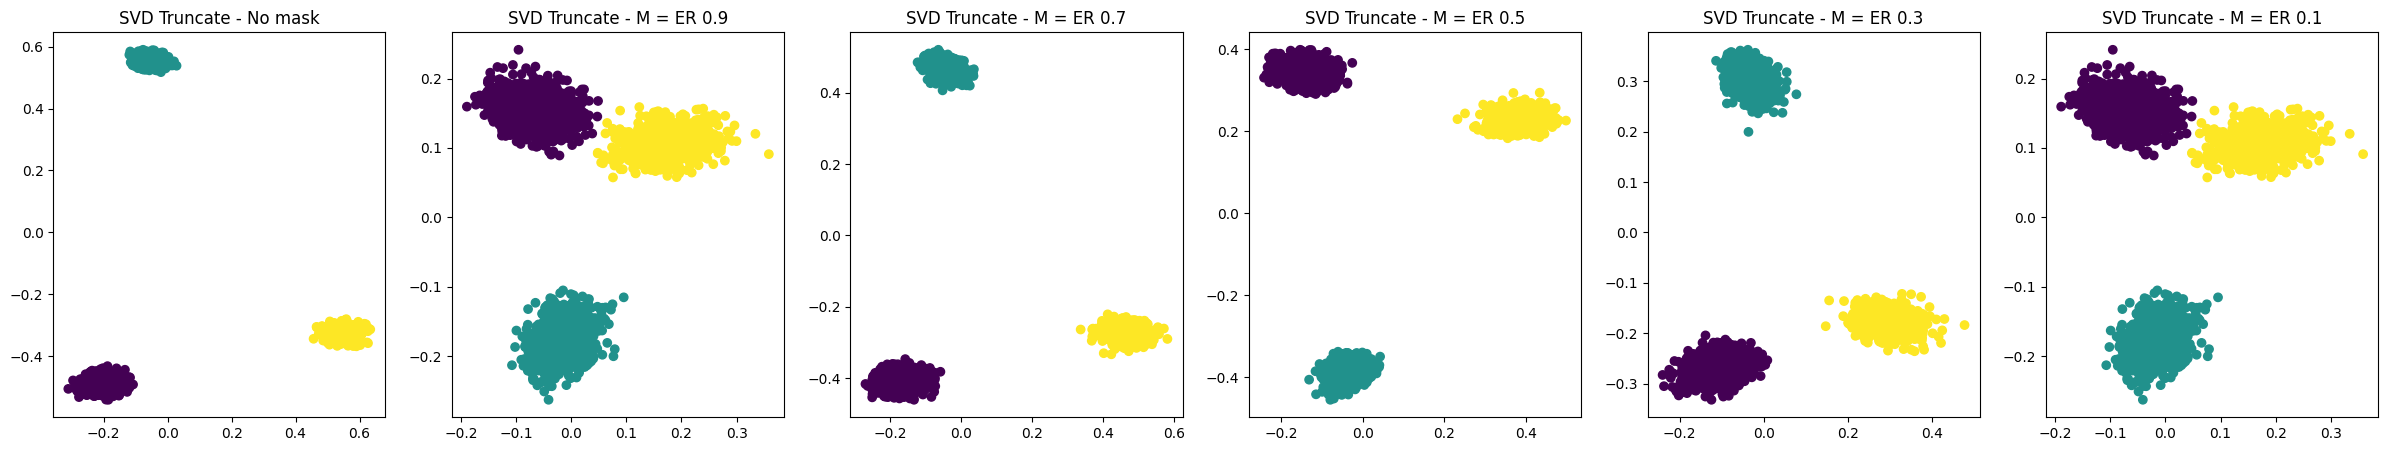

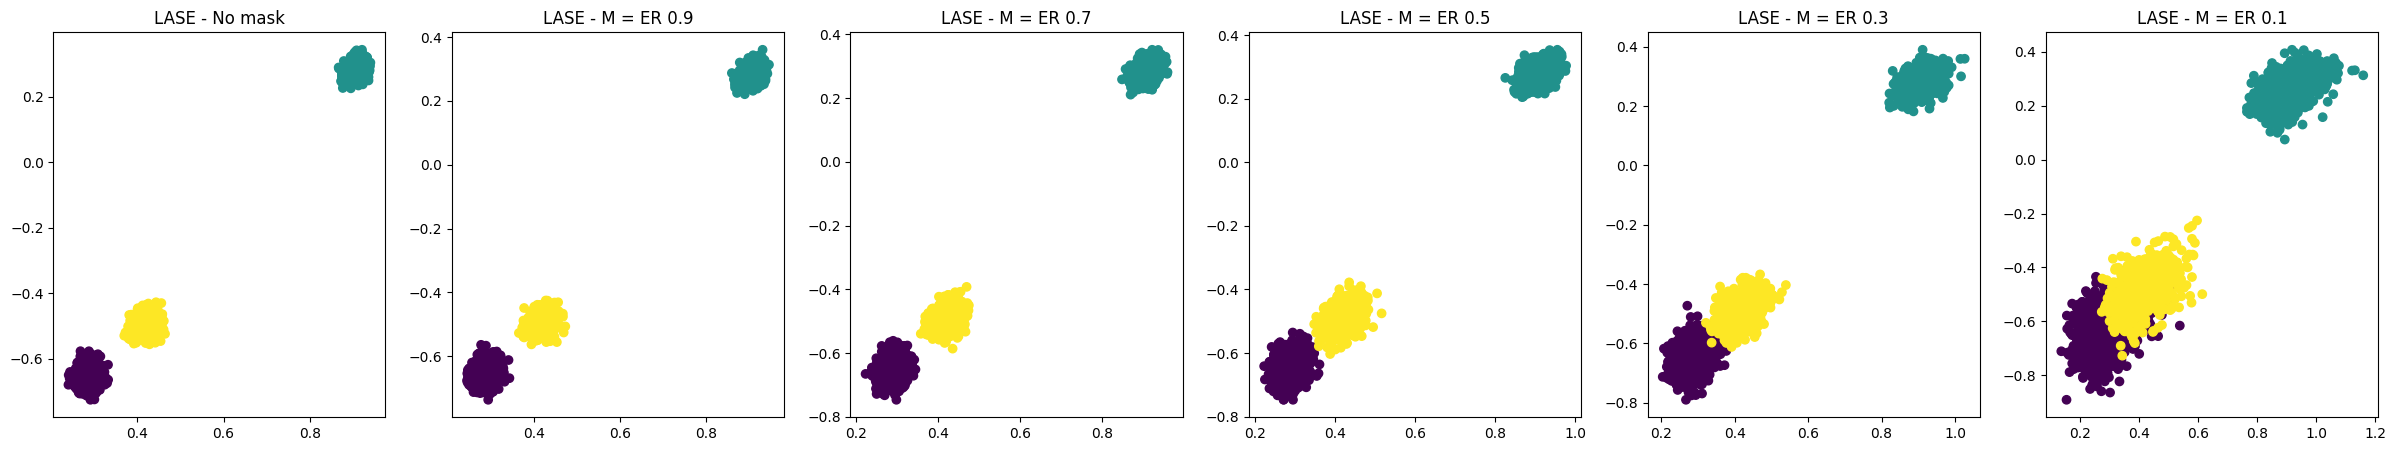

In [97]:
colors = np.concatenate((np.ones(n[0]),np.ones(n[1])*2, np.ones(n[2])*3))

fig, axes = plt.subplots(1, 6, figsize =(30,5))
axes[0].scatter(x_svd[:,0],x_svd[:,1], c=colors)
axes[0].set_title('SVD Truncate - No mask')
axes[1].scatter(x_svd_m1[:,0],x_svd_m1[:,1], c=colors)
axes[1].set_title('SVD Truncate - M = ER 0.9')
axes[2].scatter(x_svd_m2[:,0],x_svd_m2[:,1], c=colors)
axes[2].set_title('SVD Truncate - M = ER 0.7')
axes[3].scatter(x_svd_m3[:,0],x_svd_m3[:,1], c=colors)
axes[3].set_title('SVD Truncate - M = ER 0.5')
axes[4].scatter(x_svd_m4[:,0],x_svd_m4[:,1], c=colors)
axes[4].set_title('SVD Truncate - M = ER 0.3')
axes[5].scatter(x_svd_m5[:,0],x_svd_m5[:,1], c=colors)
axes[5].set_title('SVD Truncate - M = ER 0.1')
plt.show()


fig, axes = plt.subplots(1, 6, figsize =(30,5))
axes[0].scatter(x_lase[:,0],x_lase[:,2], c=colors)
axes[0].set_title('LASE - No mask')
axes[1].scatter(x_lase_m1[:,0],x_lase_m1[:,2], c=colors)
axes[1].set_title('LASE - M = ER 0.9')
axes[2].scatter(x_lase_m2[:,0],x_lase_m2[:,2], c=colors)
axes[2].set_title('LASE - M = ER 0.7')
axes[3].scatter(x_lase_m3[:,0],x_lase_m3[:,2], c=colors)
axes[3].set_title('LASE - M = ER 0.5')
axes[4].scatter(x_lase_m4[:,0],x_lase_m4[:,2], c=colors)
axes[4].set_title('LASE - M = ER 0.3')
axes[5].scatter(x_lase_m5[:,0],x_lase_m5[:,2], c=colors)
axes[5].set_title('LASE - M = ER 0.1')
plt.show()

# SBM-3 subgraphs

In [12]:
lase = LASE(d, d, gd_steps)
lase.load_state_dict(torch.load('../saved_models/lase_unshared_d3_normalized_unbalanced_subgraphs_rand.pt'))
lase.to(device)
lase.eval()


d = 3
num_nodes = 1200
n = [600, 400, 200]
p = [
     [0.9, 0.2, 0.1],
     [0.2, 0.6, 0.2],
     [0.1, 0.2, 0.7]    
]

edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)

## Se crean mascaras M que "ocultan" ciertas conexiones
M1 = erdos_renyi_graph(num_nodes, 0.9, directed=False)
M2 = erdos_renyi_graph(num_nodes, 0.7, directed=False)
M3 = erdos_renyi_graph(num_nodes, 0.5, directed=False)
M4 = erdos_renyi_graph(num_nodes, 0.3, directed=False)
M5 = erdos_renyi_graph(num_nodes, 0.1, directed=False)


x = torch.rand((num_nodes, d)).to(device)

Loss LASE shared weights (5 layers) - no mask:  tensor(451.2647)
Loss LASE shared weights (5 layers) - mask 1:  tensor(427.6581)
Loss LASE shared weights (5 layers) - mask 2:  tensor(377.5352)
Loss LASE shared weights (5 layers) - mask 3:  tensor(320.1352)
Loss LASE shared weights (5 layers) - mask 4:  tensor(253.9076)
Loss LASE shared weights (5 layers) - mask 5:  tensor(283.3474)


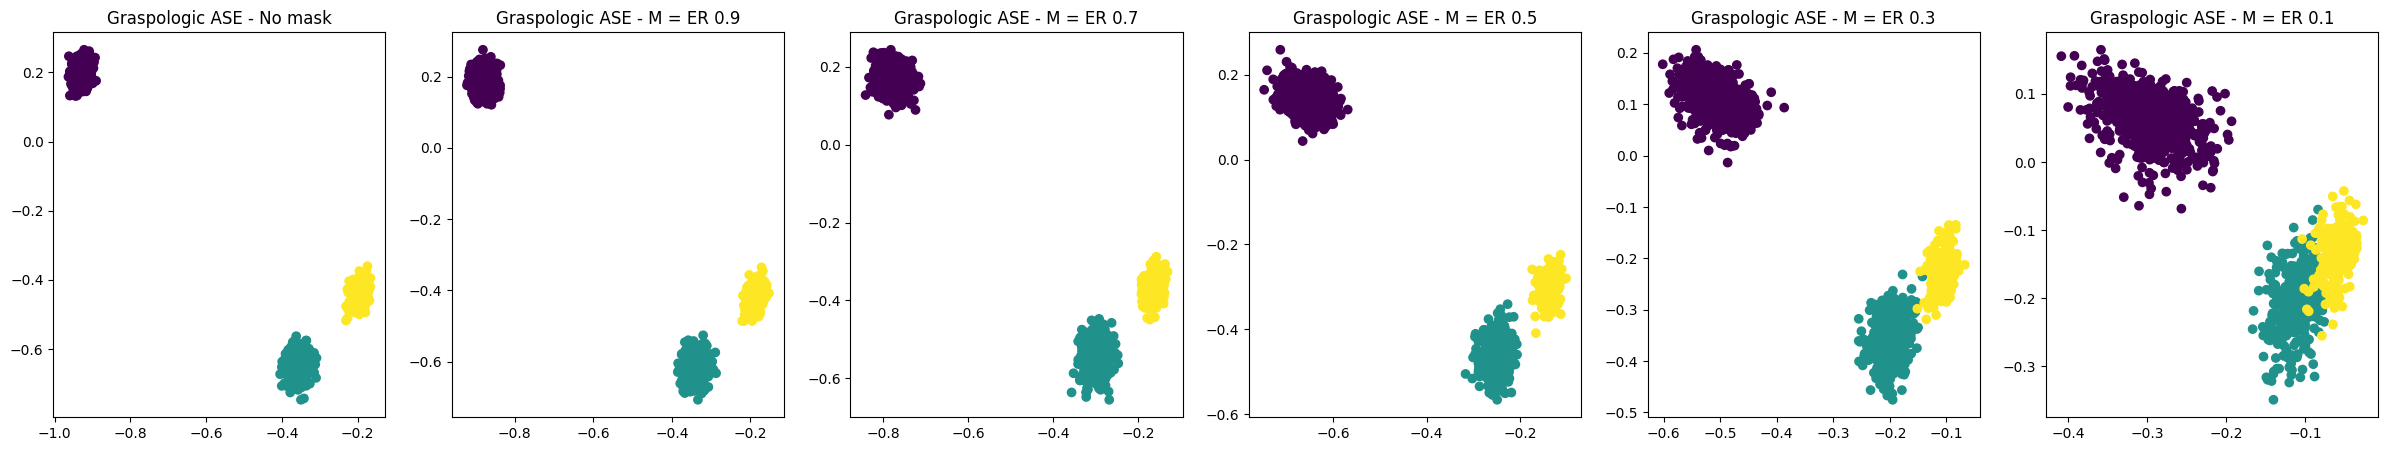

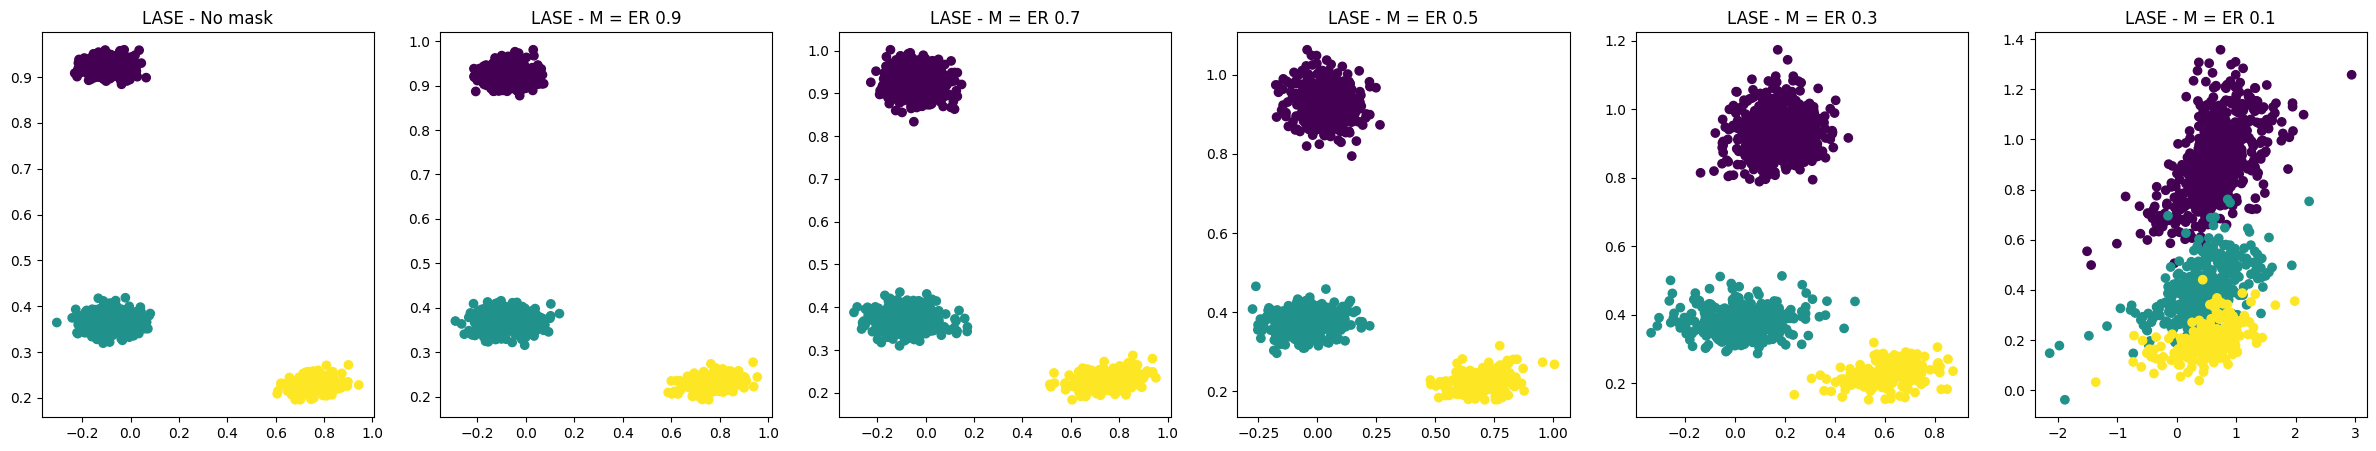

In [13]:
## Original 
x_lase = lase(x, edge_index, edge_index_2, mask)
x_lase = x_lase.detach()
loss = torch.norm((x_lase@x_lase.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(edge_index_2).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - no mask: ", loss)
x_lase = x_lase.to('cpu')

adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0).numpy()
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
x_ase = ase.fit_transform(adj_matrix)
x_ase = torch.from_numpy(x_ase)

## Mask 1
x_lase_m1 = lase(x, edge_index, edge_index_2, M1)
x_lase_m1 = x_lase_m1.detach()
loss = torch.norm((x_lase_m1@x_lase_m1.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M1).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 1: ", loss)
x_lase_m1 = x_lase_m1.to('cpu')

adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0).numpy()
mask_matrix = to_dense_adj(M1).squeeze(0).numpy()
masked_adj = adj_matrix*mask_matrix
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
x_ase_m1 = ase.fit_transform(masked_adj)
x_ase_m1 = torch.from_numpy(x_ase_m1)

## Mask 2
x_lase_m2 = lase(x, edge_index, edge_index_2, M2)
x_lase_m2 = x_lase_m2.detach()
loss = torch.norm((x_lase_m2@x_lase_m2.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M2).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 2: ", loss)
x_lase_m2 = x_lase_m2.to('cpu')

adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0).numpy()
mask_matrix = to_dense_adj(M2).squeeze(0).numpy()
masked_adj = adj_matrix*mask_matrix
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
x_ase_m2 = ase.fit_transform(masked_adj)
x_ase_m2 = torch.from_numpy(x_ase_m2)

## Mask 3
x_lase_m3 = lase(x, edge_index, edge_index_2, M3)
x_lase_m3 = x_lase_m3.detach()
loss = torch.norm((x_lase_m3@x_lase_m3.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M3).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 3: ", loss)
x_lase_m3 = x_lase_m3.to('cpu')

adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0).numpy()
mask_matrix = to_dense_adj(M3).squeeze(0).numpy()
masked_adj = adj_matrix*mask_matrix
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
x_ase_m3 = ase.fit_transform(masked_adj)
x_ase_m3 = torch.from_numpy(x_ase_m3)


## Mask 4
x_lase_m4 = lase(x, edge_index, edge_index_2, M4)
x_lase_m4 = x_lase_m4.detach()
loss = torch.norm((x_lase_m4@x_lase_m4.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M4).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 4: ", loss)
x_lase_m4 = x_lase_m4.to('cpu')

adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0).numpy()
mask_matrix = to_dense_adj(M4).squeeze(0).numpy()
masked_adj = adj_matrix*mask_matrix
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
x_ase_m4 = ase.fit_transform(masked_adj)
x_ase_m4 = torch.from_numpy(x_ase_m4)


## Mask 5
x_lase_m5 = lase(x, edge_index, edge_index_2, M5)
x_lase_m5 = x_lase_m5.detach()
loss = torch.norm((x_lase_m5@x_lase_m5.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M5).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 5: ", loss)
x_lase_m5 = x_lase_m5.to('cpu')

adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0).numpy()
mask_matrix = to_dense_adj(M5).squeeze(0).numpy()
masked_adj = adj_matrix*mask_matrix
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
x_ase_m5 = ase.fit_transform(masked_adj)
x_ase_m5 = torch.from_numpy(x_ase_m5)


colors = np.concatenate((np.ones(n[0]),np.ones(n[1])*2, np.ones(n[2])*3))

fig, axes = plt.subplots(1, 6, figsize =(30,5))
axes[0].scatter(x_ase[:,0],x_ase[:,1], c=colors)
axes[0].set_title('Graspologic ASE - No mask')
axes[1].scatter(x_ase_m1[:,0],x_ase_m1[:,1], c=colors)
axes[1].set_title('Graspologic ASE - M = ER 0.9')
axes[2].scatter(x_ase_m2[:,0],x_ase_m2[:,1], c=colors)
axes[2].set_title('Graspologic ASE - M = ER 0.7')
axes[3].scatter(x_ase_m3[:,0],x_ase_m3[:,1], c=colors)
axes[3].set_title('Graspologic ASE - M = ER 0.5')
axes[4].scatter(x_ase_m4[:,0],x_ase_m4[:,1], c=colors)
axes[4].set_title('Graspologic ASE - M = ER 0.3')
axes[5].scatter(x_ase_m5[:,0],x_ase_m5[:,1], c=colors)
axes[5].set_title('Graspologic ASE - M = ER 0.1')
plt.show()


fig, axes = plt.subplots(1, 6, figsize =(30,5))
axes[0].scatter(x_lase[:,0],x_lase[:,1], c=colors)
axes[0].set_title('LASE - No mask')
axes[1].scatter(x_lase_m1[:,0],x_lase_m1[:,1], c=colors)
axes[1].set_title('LASE - M = ER 0.9')
axes[2].scatter(x_lase_m2[:,0],x_lase_m2[:,1], c=colors)
axes[2].set_title('LASE - M = ER 0.7')
axes[3].scatter(x_lase_m3[:,0],x_lase_m3[:,1], c=colors)
axes[3].set_title('LASE - M = ER 0.5')
axes[4].scatter(x_lase_m4[:,0],x_lase_m4[:,1], c=colors)
axes[4].set_title('LASE - M = ER 0.3')
axes[5].scatter(x_lase_m5[:,0],x_lase_m5[:,1], c=colors)
axes[5].set_title('LASE - M = ER 0.1')
plt.show()

# SBM-3 - random

In [6]:
d = 3
gd_steps = 5
device = 'cpu'

lase = LASE(d, d, gd_steps)
lase.load_state_dict(torch.load('../saved_models/lase_unshared_d3_normalized_unbalanced_rand.pt'))
lase.to(device)
lase.eval()

num_nodes = 3000
n = [1400, 1000, 600]
p = [
     [0.5, 0.1, 0.3],
     [0.1, 0.9, 0.2], 
     [0.3, 0.2, 0.7]
]

edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)

## Se crean mascaras M que "ocultan" ciertas conexiones
M1 = erdos_renyi_graph(num_nodes, 0.9, directed=False)
M2 = erdos_renyi_graph(num_nodes, 0.7, directed=False)
M3 = erdos_renyi_graph(num_nodes, 0.5, directed=False)
M4 = erdos_renyi_graph(num_nodes, 0.3, directed=False)
M5 = erdos_renyi_graph(num_nodes, 0.1, directed=False)

x = torch.rand((num_nodes, d)).to(device)

Loss LASE shared weights (5 layers) - no mask:  tensor(1228.5222)
Loss LASE shared weights (5 layers) - mask 1:  tensor(1165.0660)
Loss LASE shared weights (5 layers) - mask 2:  tensor(1026.9542)
Loss LASE shared weights (5 layers) - mask 3:  tensor(867.4501)
Loss LASE shared weights (5 layers) - mask 4:  tensor(671.9943)
Loss LASE shared weights (5 layers) - mask 5:  tensor(387.1512)


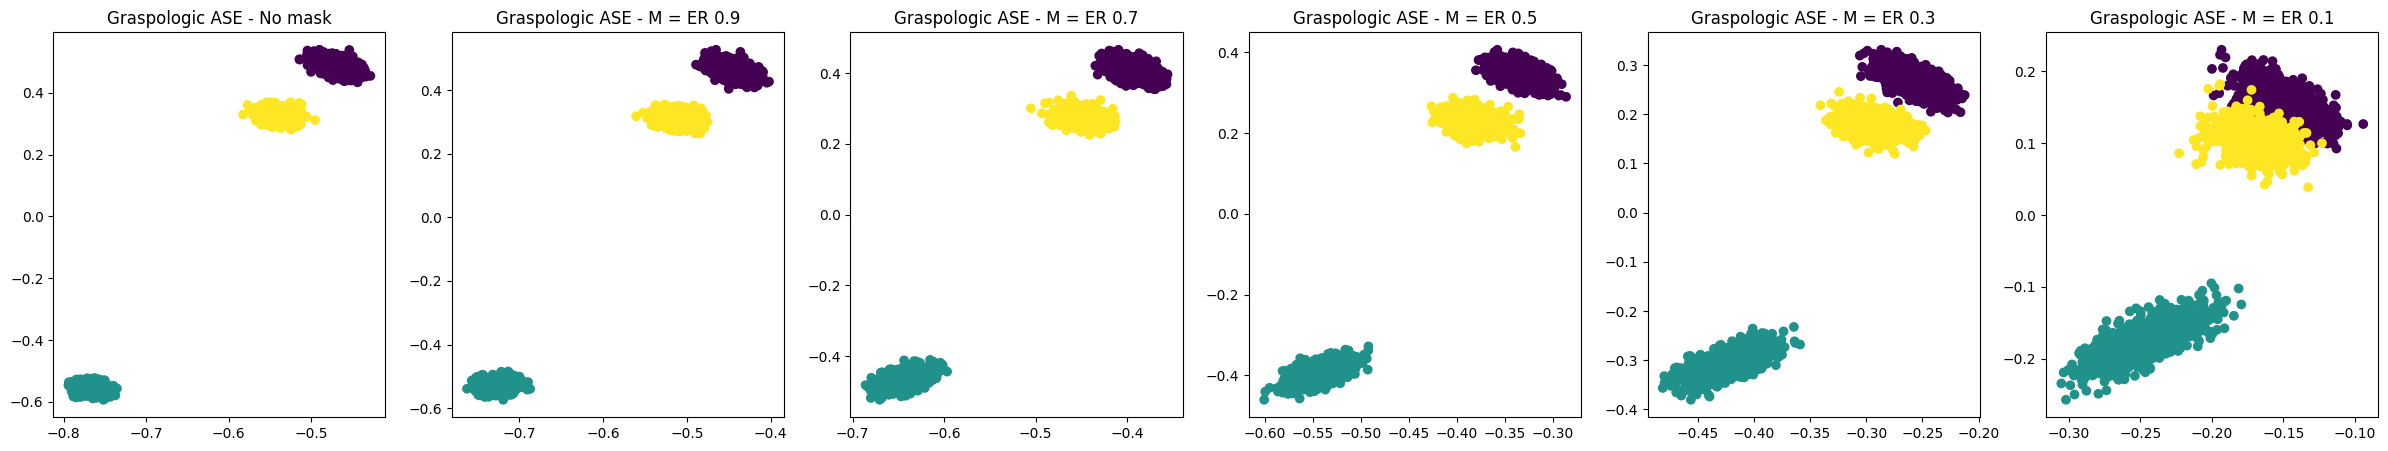

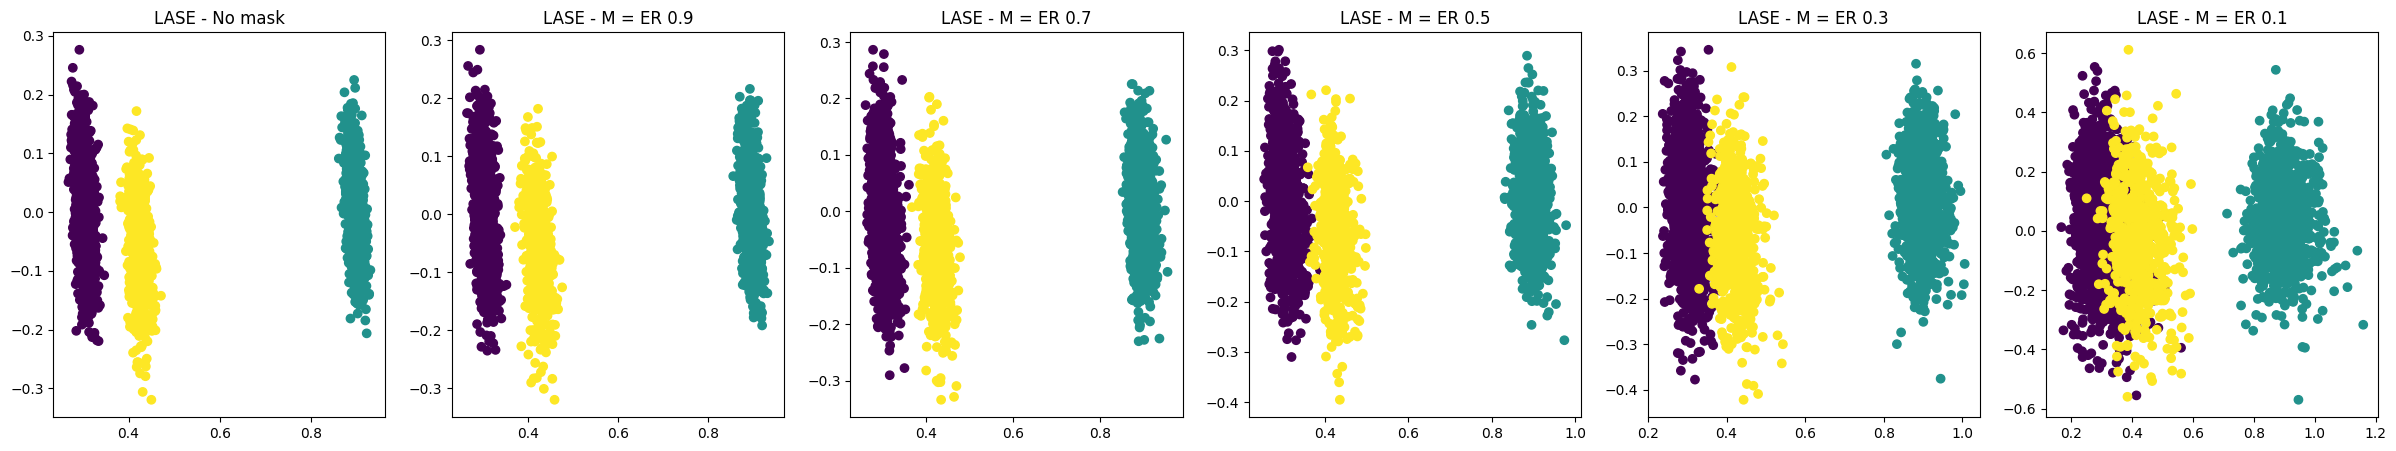

In [7]:
## Original 
x_lase = lase(x, edge_index, edge_index_2, mask)
x_lase = x_lase.detach()
loss = torch.norm((x_lase@x_lase.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(edge_index_2).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - no mask: ", loss)
x_lase = x_lase.to('cpu')

adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0).numpy()
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
x_ase = ase.fit_transform(adj_matrix)
x_ase = torch.from_numpy(x_ase)

## Mask 1
x_lase_m1 = lase(x, edge_index, edge_index_2, M1)
x_lase_m1 = x_lase_m1.detach()
loss = torch.norm((x_lase_m1@x_lase_m1.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M1).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 1: ", loss)
x_lase_m1 = x_lase_m1.to('cpu')

adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0).numpy()
mask_matrix = to_dense_adj(M1).squeeze(0).numpy()
masked_adj = adj_matrix*mask_matrix
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
x_ase_m1 = ase.fit_transform(masked_adj)
x_ase_m1 = torch.from_numpy(x_ase_m1)

## Mask 2
x_lase_m2 = lase(x, edge_index, edge_index_2, M2)
x_lase_m2 = x_lase_m2.detach()
loss = torch.norm((x_lase_m2@x_lase_m2.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M2).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 2: ", loss)
x_lase_m2 = x_lase_m2.to('cpu')

adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0).numpy()
mask_matrix = to_dense_adj(M2).squeeze(0).numpy()
masked_adj = adj_matrix*mask_matrix
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
x_ase_m2 = ase.fit_transform(masked_adj)
x_ase_m2 = torch.from_numpy(x_ase_m2)

## Mask 3
x_lase_m3 = lase(x, edge_index, edge_index_2, M3)
x_lase_m3 = x_lase_m3.detach()
loss = torch.norm((x_lase_m3@x_lase_m3.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M3).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 3: ", loss)
x_lase_m3 = x_lase_m3.to('cpu')

adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0).numpy()
mask_matrix = to_dense_adj(M3).squeeze(0).numpy()
masked_adj = adj_matrix*mask_matrix
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
x_ase_m3 = ase.fit_transform(masked_adj)
x_ase_m3 = torch.from_numpy(x_ase_m3)


## Mask 4
x_lase_m4 = lase(x, edge_index, edge_index_2, M4)
x_lase_m4 = x_lase_m4.detach()
loss = torch.norm((x_lase_m4@x_lase_m4.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M4).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 4: ", loss)
x_lase_m4 = x_lase_m4.to('cpu')

adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0).numpy()
mask_matrix = to_dense_adj(M4).squeeze(0).numpy()
masked_adj = adj_matrix*mask_matrix
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
x_ase_m4 = ase.fit_transform(masked_adj)
x_ase_m4 = torch.from_numpy(x_ase_m4)


## Mask 5
x_lase_m5 = lase(x, edge_index, edge_index_2, M5)
x_lase_m5 = x_lase_m5.detach()
loss = torch.norm((x_lase_m5@x_lase_m5.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M5).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 5: ", loss)
x_lase_m5 = x_lase_m5.to('cpu')

adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0).numpy()
mask_matrix = to_dense_adj(M5).squeeze(0).numpy()
masked_adj = adj_matrix*mask_matrix
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
x_ase_m5 = ase.fit_transform(masked_adj)
x_ase_m5 = torch.from_numpy(x_ase_m5)


colors = np.concatenate((np.ones(n[0]),np.ones(n[1])*2, np.ones(n[2])*3))

fig, axes = plt.subplots(1, 6, figsize =(30,5))
axes[0].scatter(x_ase[:,0],x_ase[:,1], c=colors)
axes[0].set_title('Graspologic ASE - No mask')
axes[1].scatter(x_ase_m1[:,0],x_ase_m1[:,1], c=colors)
axes[1].set_title('Graspologic ASE - M = ER 0.9')
axes[2].scatter(x_ase_m2[:,0],x_ase_m2[:,1], c=colors)
axes[2].set_title('Graspologic ASE - M = ER 0.7')
axes[3].scatter(x_ase_m3[:,0],x_ase_m3[:,1], c=colors)
axes[3].set_title('Graspologic ASE - M = ER 0.5')
axes[4].scatter(x_ase_m4[:,0],x_ase_m4[:,1], c=colors)
axes[4].set_title('Graspologic ASE - M = ER 0.3')
axes[5].scatter(x_ase_m5[:,0],x_ase_m5[:,1], c=colors)
axes[5].set_title('Graspologic ASE - M = ER 0.1')
plt.show()


fig, axes = plt.subplots(1, 6, figsize =(30,5))
axes[0].scatter(x_lase[:,0],x_lase[:,1], c=colors)
axes[0].set_title('LASE - No mask')
axes[1].scatter(x_lase_m1[:,0],x_lase_m1[:,1], c=colors)
axes[1].set_title('LASE - M = ER 0.9')
axes[2].scatter(x_lase_m2[:,0],x_lase_m2[:,1], c=colors)
axes[2].set_title('LASE - M = ER 0.7')
axes[3].scatter(x_lase_m3[:,0],x_lase_m3[:,1], c=colors)
axes[3].set_title('LASE - M = ER 0.5')
axes[4].scatter(x_lase_m4[:,0],x_lase_m4[:,1], c=colors)
axes[4].set_title('LASE - M = ER 0.3')
axes[5].scatter(x_lase_m5[:,0],x_lase_m5[:,1], c=colors)
axes[5].set_title('LASE - M = ER 0.1')
plt.show()

# SBM-5

In [6]:
d = 5
gd_steps = 5
device = 'cpu'

lase = GD_Unroll_w_norm(d, d, gd_steps)
lase.load_state_dict(torch.load('../../saved_models/paper/lase_unshared_d5_normalized_unbalanced.pt'))
lase.to(device)
lase.eval()

num_nodes = 1750
n = [500, 250, 450, 300, 250]
p = [
    [0.9, 0.1, 0.2, 0.2, 0.1],
    [0.1, 0.8, 0.1, 0.1, 0.2],
    [0.2, 0.1, 0.7, 0.2, 0.1],
    [0.2, 0.1, 0.2, 0.8, 0.2],
    [0.1, 0.2, 0.1, 0.2, 0.9],
]

edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)

## Se crean mascaras M que "ocultan" ciertas conexiones
M1 = erdos_renyi_graph(num_nodes, 0.9, directed=False)
M2 = erdos_renyi_graph(num_nodes, 0.7, directed=False)
M3 = erdos_renyi_graph(num_nodes, 0.5, directed=False)
M4 = erdos_renyi_graph(num_nodes, 0.3, directed=False)
M5 = erdos_renyi_graph(num_nodes, 0.1, directed=False)

x  = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2).to(device)

# Masked Attention

Loss LASE shared weights (5 layers) - no mask:  tensor(632.5436)
Loss LASE shared weights (5 layers) - mask 1:  tensor(599.0853)
Loss LASE shared weights (5 layers) - mask 2:  tensor(528.3268)
Loss LASE shared weights (5 layers) - mask 3:  tensor(446.7237)
Loss LASE shared weights (5 layers) - mask 4:  tensor(346.4229)
Loss LASE shared weights (5 layers) - mask 5:  tensor(201.6297)


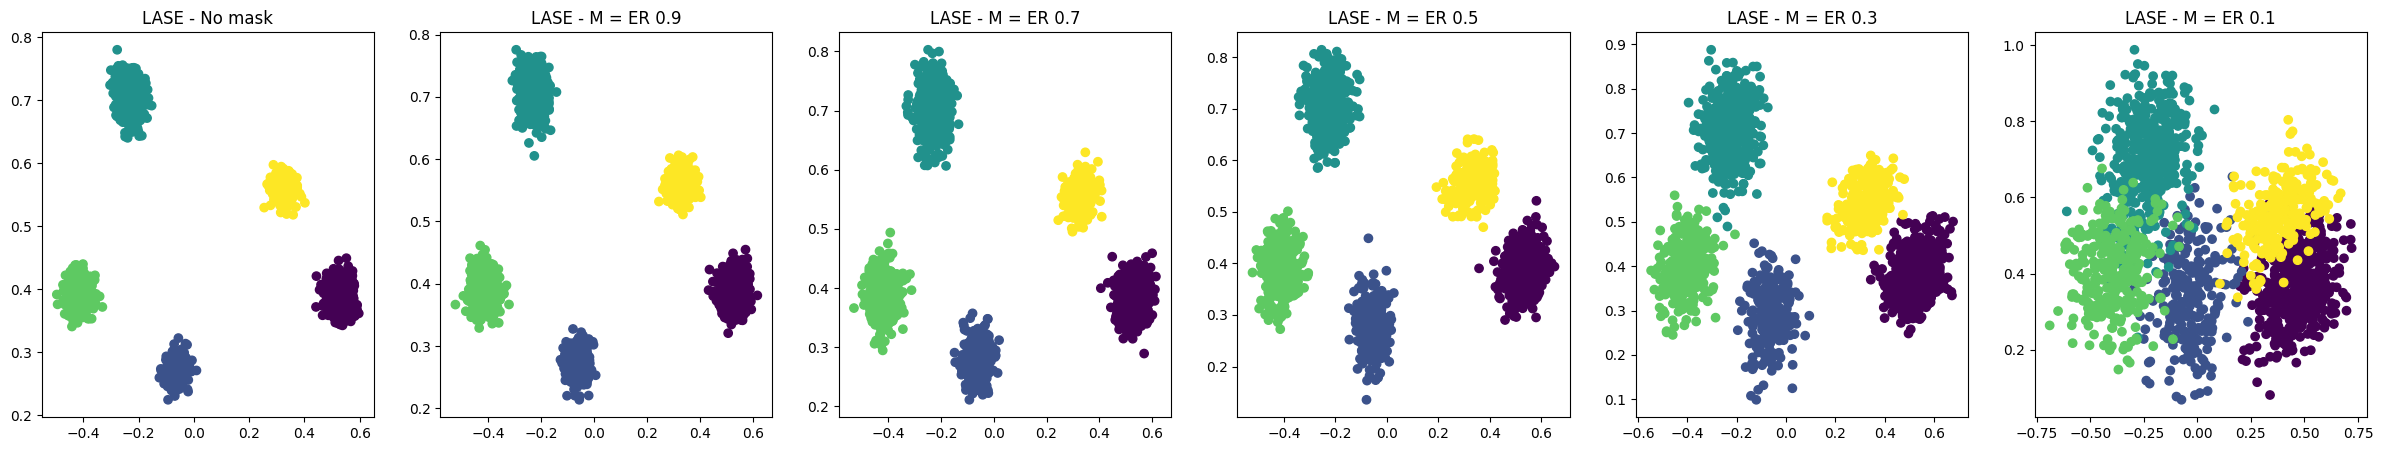

In [7]:
## Original 
x_lase = lase(x, edge_index, edge_index_2, mask)
x_lase = x_lase.detach()
loss = torch.norm((x_lase@x_lase.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(edge_index_2).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - no mask: ", loss)
x_lase = x_lase.to('cpu')

## Mask 1
x_lase_m1 = lase(x, edge_index, edge_index_2, M1)
x_lase_m1 = x_lase_m1.detach()
loss = torch.norm((x_lase_m1@x_lase_m1.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M1).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 1: ", loss)
x_lase_m1 = x_lase_m1.to('cpu')

## Mask 2
x_lase_m2 = lase(x, edge_index, edge_index_2, M2)
x_lase_m2 = x_lase_m2.detach()
loss = torch.norm((x_lase_m2@x_lase_m2.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M2).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 2: ", loss)
x_lase_m2 = x_lase_m2.to('cpu')

## Mask 3
x_lase_m3 = lase(x, edge_index, edge_index_2, M3)
x_lase_m3 = x_lase_m3.detach()
loss = torch.norm((x_lase_m3@x_lase_m3.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M3).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 3: ", loss)
x_lase_m3 = x_lase_m3.to('cpu')

## Mask 4
x_lase_m4 = lase(x, edge_index, edge_index_2, M4)
x_lase_m4 = x_lase_m4.detach()
loss = torch.norm((x_lase_m4@x_lase_m4.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M4).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 4: ", loss)
x_lase_m4 = x_lase_m4.to('cpu')

## Mask 5
x_lase_m5 = lase(x, edge_index, edge_index_2, M5)
x_lase_m5 = x_lase_m5.detach()
loss = torch.norm((x_lase_m5@x_lase_m5.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M5).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 5: ", loss)
x_lase_m5 = x_lase_m5.to('cpu')

colors = np.concatenate((np.ones(n[0]),np.ones(n[1])*2,np.ones(n[2])*3,np.ones(n[3])*4,np.ones(n[4])*5))

fig, axes = plt.subplots(1, 6, figsize =(30,5))
axes[0].scatter(x_lase[:,0],x_lase[:,1], c=colors)
axes[0].set_title('LASE - No mask')
axes[1].scatter(x_lase_m1[:,0],x_lase_m1[:,1], c=colors)
axes[1].set_title('LASE - M = ER 0.9')
axes[2].scatter(x_lase_m2[:,0],x_lase_m2[:,1], c=colors)
axes[2].set_title('LASE - M = ER 0.7')
axes[3].scatter(x_lase_m3[:,0],x_lase_m3[:,1], c=colors)
axes[3].set_title('LASE - M = ER 0.5')
axes[4].scatter(x_lase_m4[:,0],x_lase_m4[:,1], c=colors)
axes[4].set_title('LASE - M = ER 0.3')
axes[5].scatter(x_lase_m5[:,0],x_lase_m5[:,1], c=colors)
axes[5].set_title('LASE - M = ER 0.1')
plt.show()

# Re-train

Loss LASE shared weights (5 layers) - mask 4:  tensor(351.3521)
Loss LASE shared weights (5 layers) - mask 5:  tensor(235.9808)


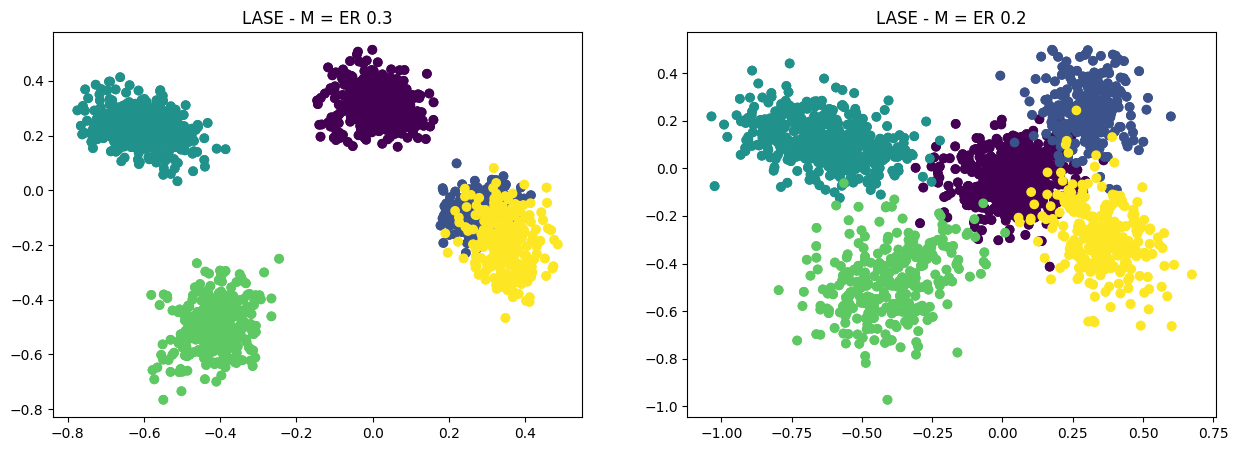

In [10]:
lase_ER03 = GD_Unroll_w_norm(d, d, gd_steps)
lase_ER03.load_state_dict(torch.load('../../saved_models/paper/lase_unshared_d5_normalized_unbalanced_ER03.pt'))
lase_ER03.to(device)
lase_ER03.eval()

lase_ER01 = GD_Unroll_w_norm(d, d, gd_steps)
lase_ER01.load_state_dict(torch.load('../../saved_models/paper/lase_unshared_d5_normalized_unbalanced_ER01.pt'))
lase_ER01.to(device)
lase_ER01.eval()

## Mask 4
x_lase_m4 = lase_ER03(x, edge_index, edge_index_2, M4)
x_lase_m4 = x_lase_m4.detach()
loss = torch.norm((x_lase_m4@x_lase_m4.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M4).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 4: ", loss)
x_lase_m4 = x_lase_m4.to('cpu')


## Mask 5
x_lase_m5 = lase_ER01(x, edge_index, edge_index_2, M5)
x_lase_m5 = x_lase_m5.detach()
loss = torch.norm((x_lase_m5@x_lase_m5.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M5).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 5: ", loss)
x_lase_m5 = x_lase_m5.to('cpu')


fig, axes = plt.subplots(1, 2, figsize =(15,5))
axes[0].scatter(x_lase_m4[:,0],x_lase_m4[:,1], c=colors)
axes[0].scatter(x_lase_m4[:,0],x_lase_m4[:,1], c=colors)
axes[0].set_title('LASE - M = ER 0.3')
axes[1].scatter(x_lase_m5[:,0],x_lase_m5[:,1], c=colors)
axes[1].scatter(x_lase_m5[:,0],x_lase_m5[:,1], c=colors)
axes[1].set_title('LASE - M = ER 0.2')
plt.show()


# Unmasked attention

In [ ]:
from models.RDPG_GD_Unroll_unshared_normalized_v3 import GD_Unroll as GD_Unroll_w_norm_2


## Original 
x_lase = lase2(x, edge_index, edge_index_2, mask = edge_index_2)
x_lase = x_lase.detach()
loss = torch.norm((x_lase@x_lase.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(edge_index_2).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - no mask: ", loss)
x_lase = x_lase.to('cpu')

## Mask 1
x_lase_m1 = lase2(x, edge_index, edge_index_2, M1)
x_lase_m1 = x_lase_m1.detach()
loss = torch.norm((x_lase_m1@x_lase_m1.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M1).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 1: ", loss)
x_lase_m1 = x_lase_m1.to('cpu')

## Mask 2
x_lase_m2 = lase2(x, edge_index, edge_index_2, M2)
x_lase_m2 = x_lase_m2.detach()
loss = torch.norm((x_lase_m2@x_lase_m2.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M2).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 2: ", loss)
x_lase_m2 = x_lase_m2.to('cpu')

## Mask 3
x_lase_m3 = lase2(x, edge_index, edge_index_2, M3)
x_lase_m3 = x_lase_m3.detach()
loss = torch.norm((x_lase_m3@x_lase_m3.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M3).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 3: ", loss)
x_lase_m3 = x_lase_m3.to('cpu')

## Mask 4
x_lase_m4 = lase2(x, edge_index, edge_index_2, M4)
x_lase_m4 = x_lase_m4.detach()
loss = torch.norm((x_lase_m4@x_lase_m4.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M4).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 4: ", loss)
x_lase_m4 = x_lase_m4.to('cpu')

## Mask 5
x_lase_m5 = lase2(x, edge_index, edge_index_2, M5)
x_lase_m5 = x_lase_m5.detach()
loss = torch.norm((x_lase_m5@x_lase_m5.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(M5).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers) - mask 5: ", loss)
x_lase_m5 = x_lase_m5.to('cpu')

